In [1]:
import cv2
import keras
from keras.applications.imagenet_utils import preprocess_input
from keras.backend.tensorflow_backend import set_session
from keras.models import Model
from keras.preprocessing import image
from PIL import Image, ImageDraw, ImageFilter, ImageOps
import random
import matplotlib.pyplot as plt
import numpy as np
import imageio
import tensorflow as tf
import os

from ssd import SSD300
from ssd_utils import BBoxUtility

os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   # see issue #152
os.environ["CUDA_VISIBLE_DEVICES"]="-1"

%matplotlib inline
plt.rcParams['figure.figsize'] = (8, 8)
plt.rcParams['image.interpolation'] = 'nearest'

np.set_printoptions(suppress=True)

config = tf.ConfigProto()
#config.gpu_options.per_process_gpu_memory_fraction = 0.5
tf.logging.set_verbosity(tf.logging.ERROR)
set_session(tf.Session(config=config))

Using TensorFlow backend.


In [2]:
voc_classes = ['Aeroplane', 'Bicycle', 'Bird', 'Boat', 'Bottle',
               'Bus', 'Car', 'Cat', 'Chair', 'Cow', 'Diningtable',
               'Dog', 'Horse','Motorbike', 'Person', 'Pottedplant',
               'Sheep', 'Sofa', 'Train', 'Tvmonitor']
NUM_CLASSES = len(voc_classes) + 1

In [3]:
input_shape=(300, 300, 3)
model = SSD300(input_shape, num_classes=NUM_CLASSES)
model.load_weights('weights_SSD300.hdf5', by_name=True)
bbox_util = BBoxUtility(NUM_CLASSES)

In [4]:
inputs = []
images = []
img_path = './pics/people.jpg'
img = image.load_img(img_path, target_size=(300, 300))
img = image.img_to_array(img)
images.append(imageio.imread(img_path))
inputs.append(img.copy())
img_path = './pics/hunter.jpg'
img = image.load_img(img_path, target_size=(300, 300))
img = image.img_to_array(img)
images.append(imageio.imread(img_path))
inputs.append(img.copy())
img_path = './pics/baby.jpg'
img = image.load_img(img_path, target_size=(300, 300))
img = image.img_to_array(img)
images.append(imageio.imread(img_path))
inputs.append(img.copy())
img_path = './pics/cats.jpg'
img = image.load_img(img_path, target_size=(300, 300))
img = image.img_to_array(img)
images.append(imageio.imread(img_path))
inputs.append(img.copy())
img_path = './pics/birds.jpg'
img = image.load_img(img_path, target_size=(300, 300))
img = image.img_to_array(img)
images.append(imageio.imread(img_path))
inputs.append(img.copy())
img_path = './pics/illust.jpg'
img = image.load_img(img_path, target_size=(300, 300))
img = image.img_to_array(img)
images.append(imageio.imread(img_path))
inputs.append(img.copy())
img_path = './pics/illust2.jpg'
img = image.load_img(img_path, target_size=(300, 300))
img = image.img_to_array(img)
images.append(imageio.imread(img_path))
inputs.append(img.copy())
inputs = preprocess_input(np.array(inputs))

In [5]:
preds = model.predict(inputs, batch_size=1, verbose=1)

7/7 [==============================] - 4s     


In [6]:
results = bbox_util.detection_out(preds)

In [7]:
%%time
a = model.predict(inputs, batch_size=1)
b = bbox_util.detection_out(preds)

Wall time: 4.26 s


In [8]:
BLUR_RADIUS = 15
THRESHOLD = 200
COLOR_CLOUD = (255, 215, 0)
COLOR_WHITE = (255, 255, 255)
COLOR_BLACK = (0, 0, 0)

def make_suyari(base, tconf, txmin, tymin, txmax, tymax):
    h, w, _ = base.shape
    suyah = h * 0.05    
    suyari = Image.new('RGB', (w, h), COLOR_WHITE)
    draw = ImageDraw.Draw(suyari)

    y = 0
    while y < h:
        cw = random.uniform(w / 20., w + 60)
        if random.randint(0, 1) == 0:
            lx = random.uniform(-30, w / 3.)
            rx = lx + cw
        else:
            rx = random.uniform(w * 2 / 3., w + 30)
            lx = rx - cw

        drawable = True
        for i in range(tconf.shape[0]):
            xmin = txmin[i] * w
            ymin = tymin[i] * h
            xmax = txmax[i] * w
            ymax = tymax[i] * h
            if collision(lx, y, rx, y + suyah, xmin, ymin, xmax, ymax):
                drawable = False

        if drawable:
            draw.rectangle((lx, y, rx, y + suyah), fill=COLOR_BLACK)

        y = y + suyah * 0.8

    suyari = suyari.filter(ImageFilter.GaussianBlur(BLUR_RADIUS))
    suyari = suyari.convert('L').point(lambda x: 0 if x < THRESHOLD else 255, '1').convert('L')
    mask = ImageOps.colorize(suyari, black=COLOR_WHITE, white=COLOR_BLACK)
    suyari = ImageOps.colorize(suyari, black=COLOR_CLOUD, white=COLOR_WHITE)

    mask = np.asarray(mask)
    suyari = np.asarray(suyari)
    
    return cv2.bitwise_and(cv2.bitwise_or(base, mask), suyari)

def collision(sx1, sy1, sx2, sy2, tx1, ty1, tx2, ty2):
    return (sx1 <= tx2 and tx1 <= sx2 and sy1 <= ty2 and ty1 <= sy2)

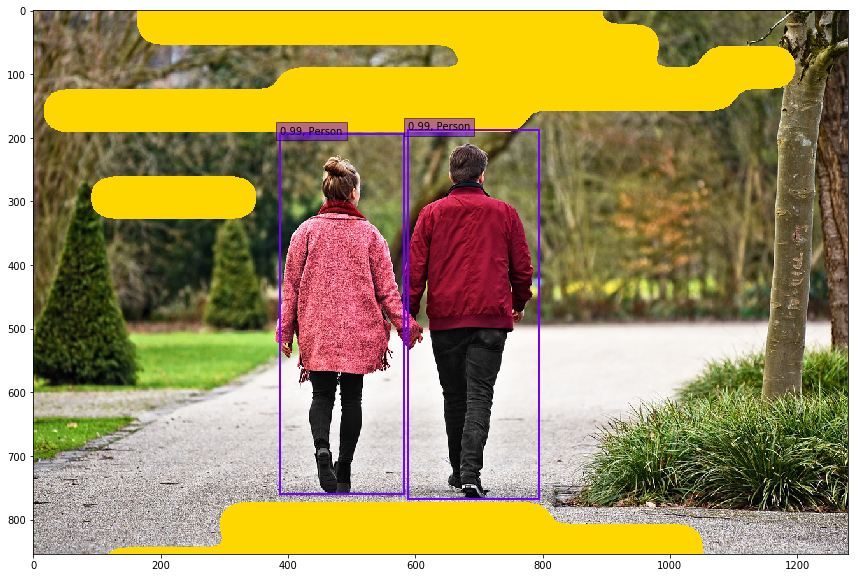

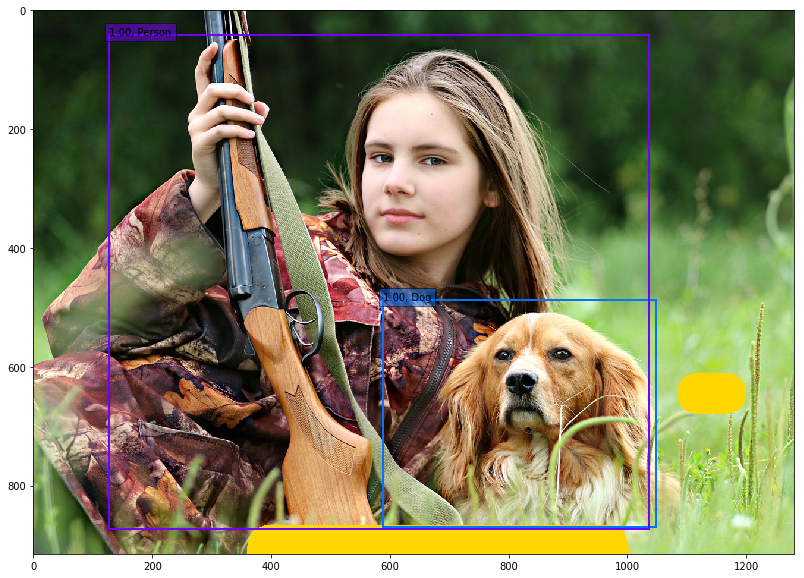

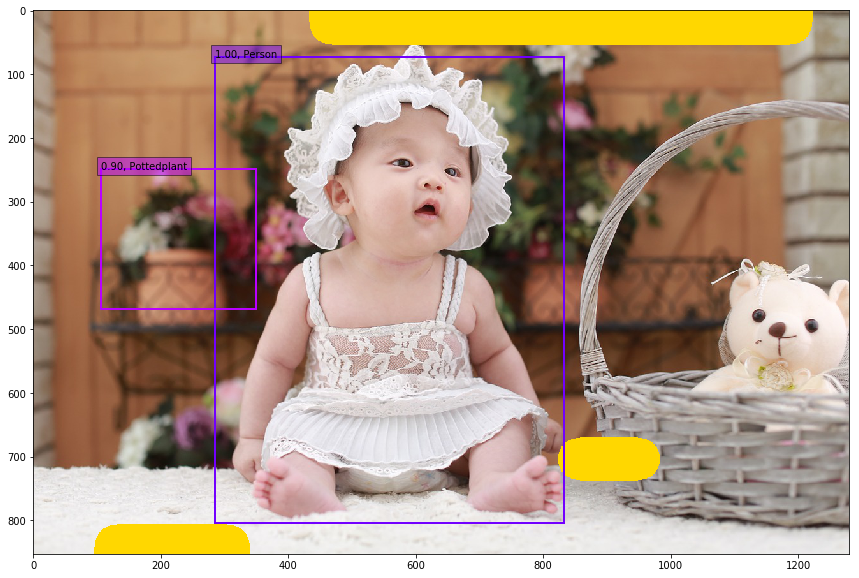

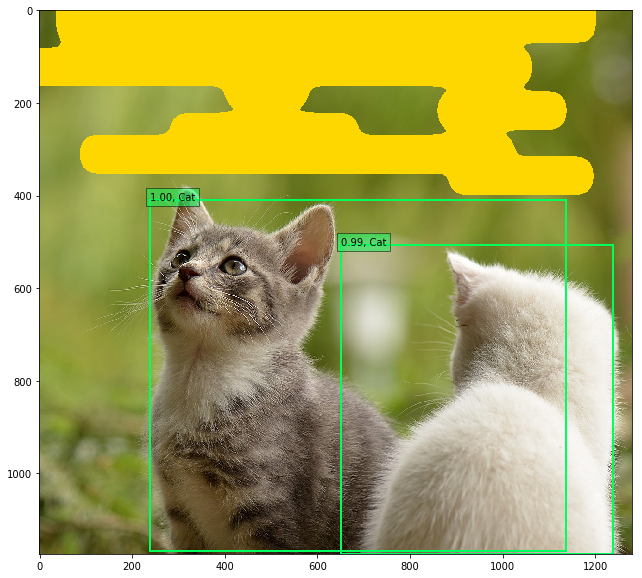

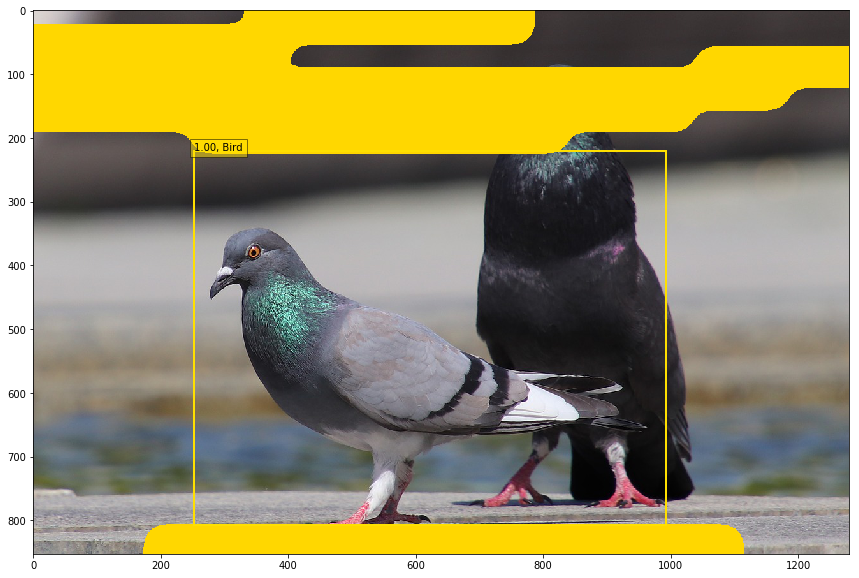

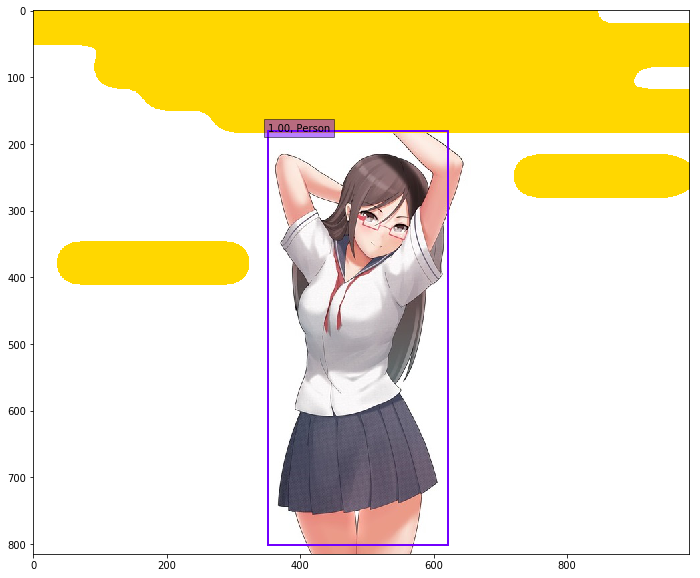

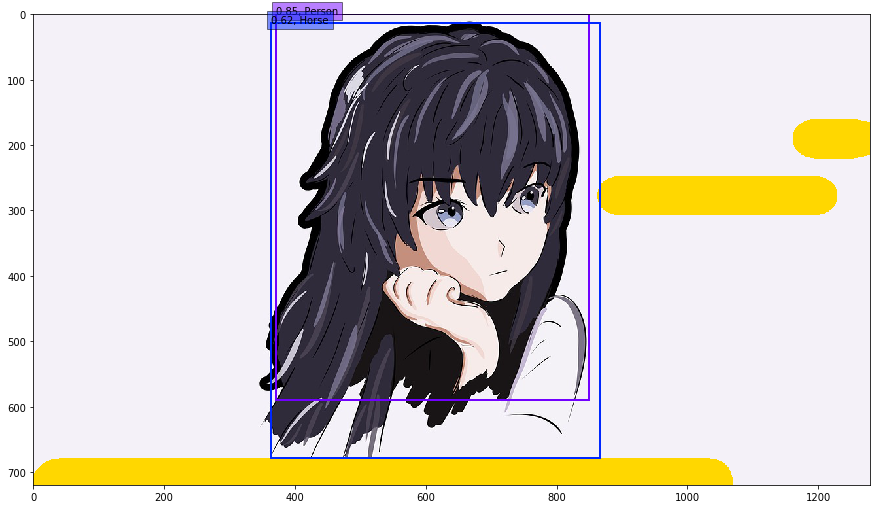

In [20]:
plt.rcParams['figure.figsize'] = (15.0, 10.0)

for i, img in enumerate(images):
    # Parse the outputs.
    det_label = results[i][:, 0]
    det_conf = results[i][:, 1]
    det_xmin = results[i][:, 2]
    det_ymin = results[i][:, 3]
    det_xmax = results[i][:, 4]
    det_ymax = results[i][:, 5]

    # Get detections with confidence higher than 0.6.
    top_indices = [i for i, conf in enumerate(det_conf) if conf >= 0.6]

    top_conf = det_conf[top_indices]
    top_label_indices = det_label[top_indices].tolist()
    top_xmin = det_xmin[top_indices]
    top_ymin = det_ymin[top_indices]
    top_xmax = det_xmax[top_indices]
    top_ymax = det_ymax[top_indices]

    colors = plt.cm.hsv(np.linspace(0, 1, 21)).tolist()

    img = make_suyari(img, top_conf, top_xmin, top_ymin, top_xmax, top_ymax)
    
    plt.imshow(img / 255.)
    currentAxis = plt.gca()

    for i in range(top_conf.shape[0]):
        xmin = int(round(top_xmin[i] * img.shape[1]))
        ymin = int(round(top_ymin[i] * img.shape[0]))
        xmax = int(round(top_xmax[i] * img.shape[1]))
        ymax = int(round(top_ymax[i] * img.shape[0]))
        score = top_conf[i]
        label = int(top_label_indices[i])
        label_name = voc_classes[label - 1]
        display_txt = '{:0.2f}, {}'.format(score, label_name)
        coords = (xmin, ymin), xmax-xmin+1, ymax-ymin+1
        color = colors[label]
        currentAxis.add_patch(plt.Rectangle(*coords, fill=False, edgecolor=color, linewidth=2))
        currentAxis.text(xmin, ymin, display_txt, bbox={'facecolor':color, 'alpha':0.5})
    
    plt.show()